## Problem 1 (20 pts)

Regression splines are a broadly applicable method for regression analysis because they can be represented and estimated as an augmented OLS problem.

A generic cubic regression spline with $K$ knots can be represented as a linear model with $K + 4$ basis expansion terms:

$$h_1(x) = 1 \text{   ;   } h_{\text{2 to 4}}(x) = \{x,x^2,x^3\}$$

$$h_{\text{5 to K + 4}} = \{(x - \xi_1)_+^3 ,  (x - \xi_2)_+^3,...,(x - \xi_K)_+^3\}$$

$$y_i = \alpha + \sum \limits_{k = 2}^{K + 4} \beta_k h_k(x_i) + \epsilon_i$$
Cubic regression splines fit a function to the data that is continuous with respect to $x$ and continuous in its first two derivatives.

For an arbitrary collection of $K \le N$ knots, prove that the cubic regression spline provides a function that is continuous in the first and second derivative at the knots.

## Data Prep

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
train_df = pd.read_csv("college_train.csv")
test_df = pd.read_csv("college_test.csv")

## Problem 2 (80 pts)

The data sets `college_train.csv` (600 observations) and `college_test.csv` (177 observations) include information about different colleges in the U.S.  We're going to use this data set to try to build a model that predicts the logarithm of out of state tuition for a college using a variety of predictors related to college quality.  Note that this data was collected back in 1995 - a magical time in U.S. history where "Run Around" by Blues Traveler was playing on the radio, Bill Clinton had a plan to actually balance the U.S. budget, and young Dr. McAlister learned to tie his shoes in Ms. Lamb's first grade class.  It is also notable that college used to be affordable!  Don't be too downtrodden when you look at this data set and see Emory's out of state tuition back then...

As always, the test set is intended to be used only for quantifying expected prediction error after choosing some trained models.  A description of the variables in the data set can be found [here](https://www.rdocumentation.org/packages/ISLR/versions/1.4/topics/College).  I've added an additional predictor called `AcceptRate` which is the acceptance rate of the school in 1995.

Note: I would recommend just recoding `Outstate = log(Outstate)` right at the beginning.

### Part 1 (20 pts.)

Let's start by looking at a single predictor - the student/faculty ratio `S.F.Ratio`.  Plot log out of state tuition against the student/faculty ratio.  Does this look linear?

Using a measure of expected prediction error appropriate for a standard linear model, find the order of global polynomial that minimizes EPE.  Be sure to note your choice and why you made it.  Using this value, train your model on the full training set and plot the prediction curve implied by the polynomial model on your graph.

Next, estimate a cubic regression spline, a cubic natural spline, and a smoothing spline using the entire training data.  For the regression spline and natural spline, you need to choose the number of knots or degrees of freedom.  I would recommend setting these to 5 to start and playing with it until you get something that looks right.  For the smoothing spline, you should choose the final form using a built-in cross-validation method (most likely GCV).  Add the prediction curve to your plot.  How do the drawn curves differ between methods?

Finally, use your polynomial model and splines to create predictions for the test set and quantify the mean squared error for the test set.  Which model performs best?  Worst?  Provide some rationale for this outcome.



<AxesSubplot:xlabel='S.F.Ratio', ylabel='Outstate'>

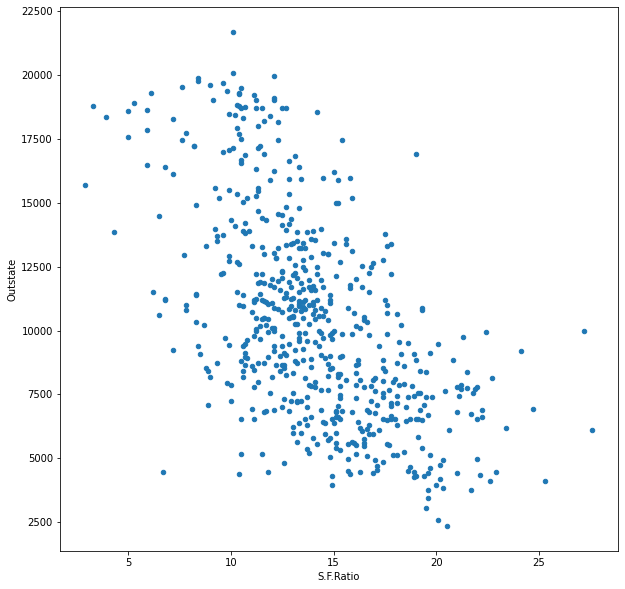

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
train_df.plot(x='S.F.Ratio', y='Outstate', kind='scatter', ax=ax)

In [4]:
from itertools import combinations
def get_basis(degree: int):
    possible_comb = []
    for j in range(1, degree+1):
        for i in list(combinations(list(range(1,degree+1)), j)):
            if degree in i: possible_comb.append(i)
    return possible_comb
get_basis(4)

[(4,), (1, 4), (2, 4), (3, 4), (1, 2, 4), (1, 3, 4), (2, 3, 4), (1, 2, 3, 4)]

In [34]:
import statsmodels.api as sm
def ols_ploy_fit(train_x, train_y, **kwargs):
    nobvs = len(train_x)
    max_param = nobvs - 2
    #if len(train_x.ravel()) > nobvs: raise Exception("err")
    ols_LOOCV = pd.DataFrame(columns=['Degree', 'Basis', 'LOOCV', 'y_pred'])
    for degree in range(1, 10):
        for basis in get_basis(degree):
            train_x_ols = pd.DataFrame()
            for paramDegree in basis:
                train_x_ols[f'S.F.Ratio^{paramDegree}'] = train_x ** paramDegree
            train_x_ols.insert(0, 'intercept', np.ones(nobvs))
            ols_reg = sm.OLS(endog=train_y, exog=train_x_ols)
            ols_reg_result = ols_reg.fit()
            train_y_predict = ols_reg_result.predict(train_x_ols)
            hat_diag = ols_reg_result.get_influence().summary_frame()['hat_diag']
            loocv_estimate = 1/nobvs * np.sum(
                ((train_y - train_y_predict)/(np.ones(nobvs) - hat_diag)) ** 2
            )
            ols_LOOCV = pd.concat([ols_LOOCV, pd.DataFrame({'Degree': degree,
             'Basis': str(basis), 'LOOCV': loocv_estimate, 'y_pred': [train_y_predict]})])
            #print(f"Degree: {basis}, LOOCV: {loocv_estimate}")
    return ols_LOOCV
ols_LOOCV = ols_ploy_fit(train_df['S.F.Ratio'].to_frame(), train_df['Outstate'])
ols_LOOCV = ols_LOOCV.sort_values('LOOCV', ascending=True)
ols_LOOCV

,Degree,Basis,LOOCV,y_pred
0,4,"(2, 4)",10502202.806711,0 7520.353769 1 11095.655159 2 ...
0,3,"(2, 3)",10510903.682888,0 7609.620004 1 11021.230731 2 ...
0,9,"(2, 8, 9)",10515456.339866,0 7382.207762 1 11156.901078 2 ...
0,9,"(2, 7, 9)",10515611.410326,0 7413.285276 1 11135.429163 2 ...
0,8,"(2, 7, 8)",10516687.897427,0 7434.019443 1 11122.242403 2 ...
...,...,...,...,...
0,5,"(5,)",13762119.983493,0 9444.121743 1 11093.715716 2 ...
0,6,"(6,)",14518063.440444,0 9807.471625 1 10937.027038 2 ...
0,7,"(7,)",15113925.031247,0 10067.396598 1 10797.231715 2 ...
0,8,"(8,)",15533862.159942,0 10235.002061 1 10686.448753 2 ...


Text(0, 0.5, 'Out-of-state tuition')

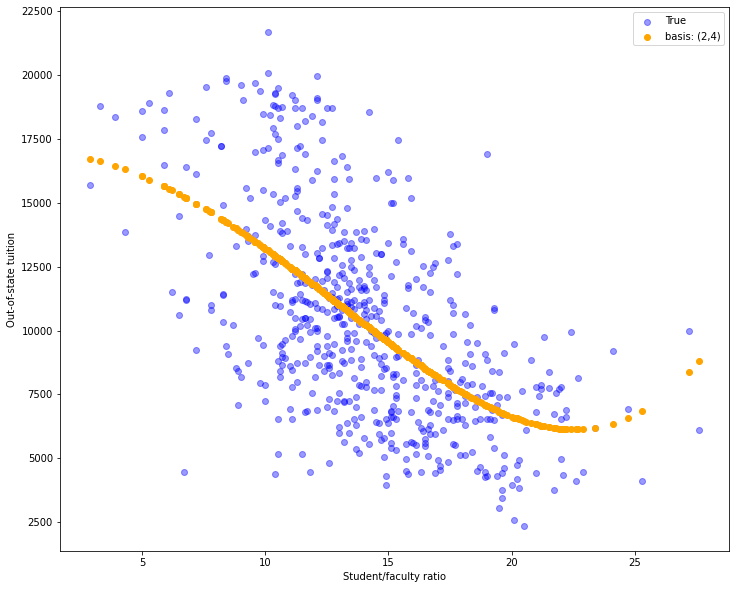

In [35]:
# USE intercept + x^2 + x^4
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(x=train_df['S.F.Ratio'], y = train_df['Outstate'], c = 'b', alpha=0.4, label='True')
ax.scatter(x=train_df['S.F.Ratio'], y = ols_LOOCV.iloc[0, -1], c='orange', label='basis: (2,4)')
ax.legend()
ax.set_xlabel('Student/faculty ratio')
ax.set_ylabel('Out-of-state tuition')

Text(0, 0.5, 'Out-of-state tuition')

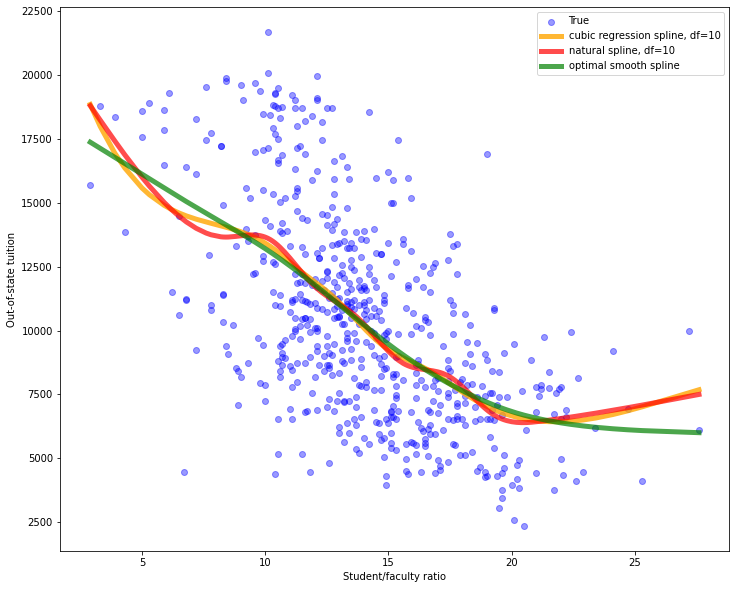

In [85]:
# regression spline / b-spline
from patsy import dmatrix

basis_x = dmatrix("bs(x, df=10, degree=3)", {"x": train_df['S.F.Ratio']})
reg_spline = sm.GLM(train_df['Outstate'], basis_x).fit()
train_y_predict =  np.dot(basis_x, reg_spline.params)
order = np.argsort(train_df['S.F.Ratio'])
train_x = train_df['S.F.Ratio'].to_numpy()[order]
train_y_predict = train_y_predict[order]

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(x=train_df['S.F.Ratio'], y = train_df['Outstate'], c = 'b', alpha=0.4, label='True')
ax.plot(train_x, train_y_predict, c='orange', lw=5, alpha=0.8, label='cubic regression spline, df=10')

# natural cubic spline

basis_x = dmatrix("cr(x, df=10)", {"x": train_df['S.F.Ratio']})
reg_spline = sm.GLM(train_df['Outstate'], basis_x).fit()
train_y_predict =  np.dot(basis_x, reg_spline.params)
order = np.argsort(train_df['S.F.Ratio'])
train_x = train_df['S.F.Ratio'].to_numpy()[order]
train_y_predict = train_y_predict[order]

ax.plot(train_x, train_y_predict, c='r', lw=5, alpha=0.7, label='natural spline, df=10')

# smooth spline w/ R

import rpy2.robjects as robjects

r_smooth_spline = robjects.r['smooth.spline']
smooth_spline_opt = r_smooth_spline(x=robjects.FloatVector(train_df['S.F.Ratio']), y=robjects.FloatVector(train_df['Outstate']))
train_y_predict = np.array(robjects.r['predict'](smooth_spline_opt,robjects.FloatVector(train_df['S.F.Ratio'])).rx('y')).ravel()
order = np.argsort(train_df['S.F.Ratio'])
train_x = train_df['S.F.Ratio'].to_numpy()[order]
train_y_predict = train_y_predict[order]
ax.plot(train_x, train_y_predict, c='green', lw=5, alpha=0.7, label='optimal smooth spline')

ax.legend()
ax.set_xlabel('Student/faculty ratio')
ax.set_ylabel('Out-of-state tuition')

### Part 2 (15 pts.)

Now, let's consider the multivariate case with all of the predictors. Let's improve on the standard linear model by using LASSO to do some variable selection and shrinkage. Fit the LASSO model to the training data and use K-fold cross validation to select a value of $\lambda$. Be sure to explain why you made the choice that you did. How many variables are used in the "optimal" model? Be sure to record the optimal $\lambda$ for later use.


In [123]:
len(train_df.drop(['Outstate', 'CollegeNames'], axis=1).columns)

18

In [414]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
train_x = train_df.drop(['Outstate', 'CollegeNames'], axis=1)\
    .assign(Private = train_df['Private']\
        .map({'Yes': 1, 'No': 0}))
train_y = train_df['Outstate']
scaler_x = StandardScaler()
train_x = pd.DataFrame(scaler_x.fit_transform(train_x), columns=train_x.columns)
lasso_reg = linear_model.LassoCV(cv=30, max_iter=10000)
lasso_reg = lasso_reg.fit(train_x, train_y)
lasso_opt_lambda = lasso_reg.alpha_
print(lasso_opt_lambda)
print(lasso_reg.coef_)

49.4595937128516
[1072.04574325   -0.          339.57377404   -0.          213.49270846
    0.         -276.37328301   -5.38223176  949.27889324   -0.
 -113.31585715  352.83882182  198.72505499 -296.05682785  523.94224883
  888.53705871  512.13111669  101.86190703]


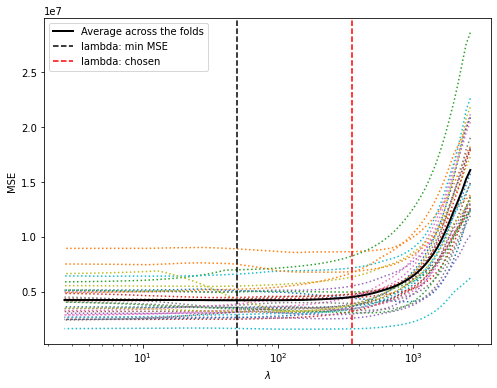

In [415]:
# plot lambda vs. MSE
plt.figure(figsize=(8,6))
plt.semilogx(lasso_reg.alphas_, lasso_reg.mse_path_, linestyle=":")
plt.plot(
    lasso_reg.alphas_,
    lasso_reg.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso_reg.alpha_, linestyle="--", color="k", label="lambda: min MSE")
plt.axvline(lasso_reg.alpha_ + 300, linestyle="--", color="red", label="lambda: chosen")
plt.xlabel(r"$\lambda$")
plt.ylabel("MSE")
plt.legend()
lambda_chosen = lasso_reg.alpha_ + 300

In [419]:
#refit with optimal lambda
lasso_reg = linear_model.Lasso(alpha=lambda_chosen, max_iter=10000)
lasso_reg = lasso_reg.fit(train_x, train_y)
lasso_reg.coef_

array([ 865.43645678,    0.        ,    0.        ,   -0.        ,
        127.80021031,    0.        ,   -0.        ,   -0.        ,
        931.08649165,   -0.        ,   -0.        ,  189.70716898,
         85.45764815, -217.21368313,  497.06446429,  897.08907167,
        502.11680207,    0.        ])

In [420]:
# estimate the MSE with k-fold cv
from sklearn.model_selection import cross_val_score
lasso_reg_cv_scores = cross_val_score(lasso_reg, train_x, train_y, cv=30, scoring='neg_mean_squared_error')
-lasso_reg_cv_scores.mean()

4541876.946160425

In [203]:
#selected variables
selected_var = train_x.columns[abs(lasso_reg.coef_) > 0.01]
# subset the data
train_x_chosen = train_df[selected_var].assign(Private = train_df['Private']\
        .map({'Yes': 1, 'No': 0}))


### Part 3 (15 pts.)

Now, let's see if we can improve on the standard LASSO regression model using a GAM. There are three approaches you can take here:

1.  Use all of the predictors.
2.  Only use the predictors selected by LASSO under your optimal model.
3.  Try to fit the GAM with an even smaller model using a subset of predictors from a higher sparsity point on the LASSO path.

Any of these approaches are fine for this problem. However, your model should include `S.F.Ratio` and `Private` (I'm pretty sure that both of these will pop up early in the LASSO path). Subset selection for GAMs is something that people are working on! There are some ways to build-in LASSO style penalties, but it's difficult to determine what a zero even is - since these are functions instead of linear combinations, what would we even shrink?

Try different combinations of linear terms, spline terms, and think-plate/tensor spline terms to try to minimize the GCV associated with your GAM. Most implementations will return this as part of the model object.

Create a plot that shows the function for each predictor. Do the marginal relationships make sense? For any 2-predictor spline terms, do they capture anything that wouldn't be captured by a linear model? Look at your function for `S.F.Ratio`. Does it look like the smoothing spline you uncovered in part 1? What does this say about the plausibility of the additivity assumption for this specific variable?

Be sure to note your "optimal" model and why you chose that one. Your search doesn't need to be exhaustive (that's impossible), just a reasonable attempt to get a good predictive model!

Compare the GCV for your chosen GAM to the K-fold CV estimate for LASSO. Does capturing non-linearities within the data improve prediction accuracy?


In [201]:
train_x_chosen.columns

Index(['Private', 'Top10perc', 'Room.Board', 'PhD', 'Terminal', 'S.F.Ratio',
       'perc.alumni', 'Expend', 'Grad.Rate'],
      dtype='object')

100% (500 of 500) |######################| Elapsed Time: 0:03:01 Time:  0:03:01
/var/folders/vw/fhlnd7k958g99z5bj0yg57vh0000gn/T/ipykernel_7834/3557710150.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     37.8141
Link Function:                     IdentityLink Log Likelihood:                                 -9565.3158
Number of Samples:                          600 AIC:                                            19208.2599
                                                AICc:                                           19213.7772
                                                GCV:                                          3771182.2177
                                                Scale:                                        3345928.3102
                                                Pseudo R-Squared:                                   0.8049
Feature Function                  Lam

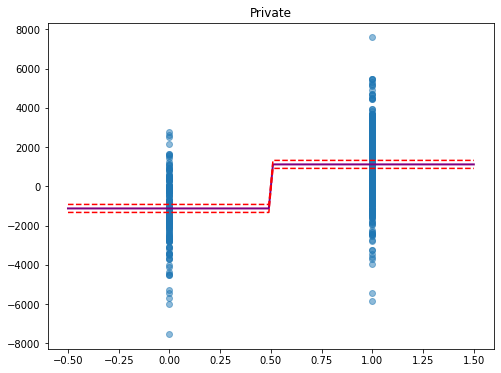

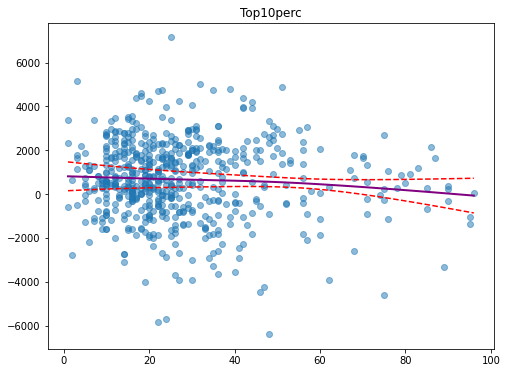

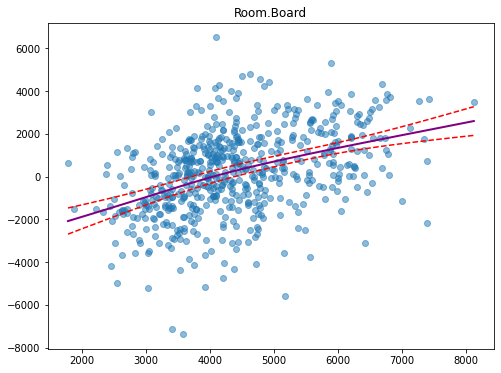

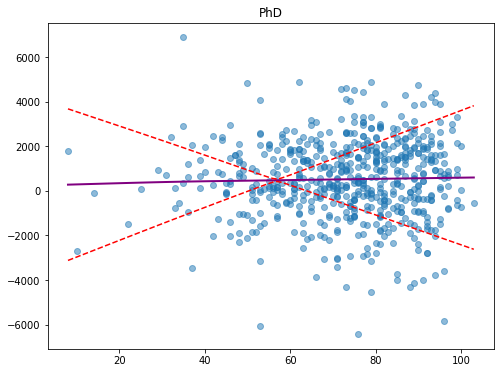

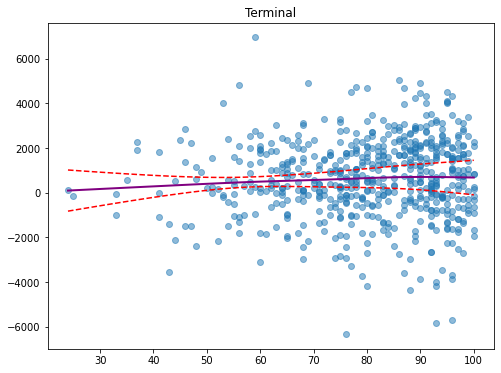

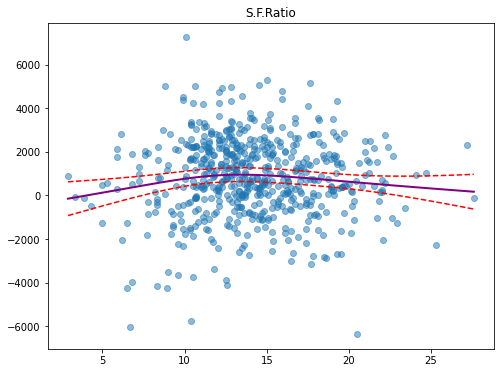

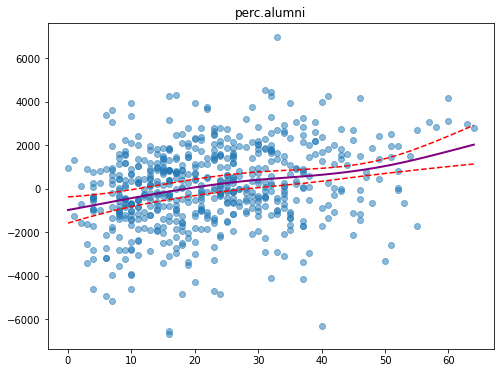

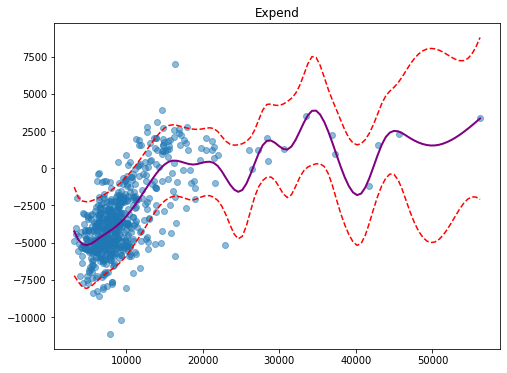

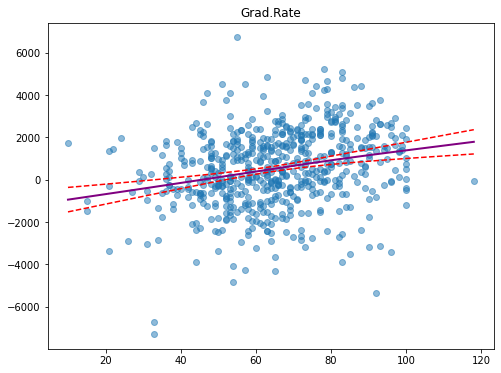

[3, 7]
[5, 8]


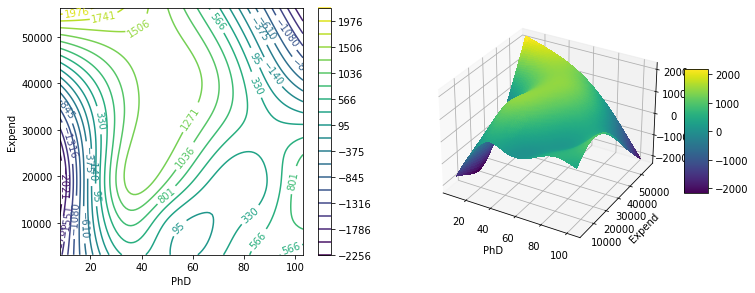

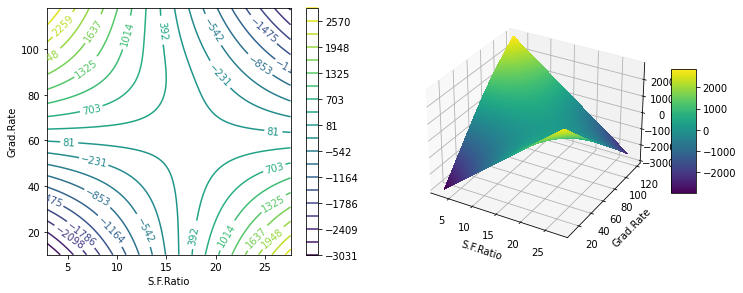

In [368]:
from pygam import GAM, l, s, f, te

gam_model = GAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + te(3,7)+ te(5,8))

#grid search on lambda
lambdas = 10 ** (np.random.random(6500).reshape(500, 13) *8 - 4) # 10^-4 to 10^4

gam_model = gam_model.gridsearch(train_x_chosen.to_numpy(), train_y.to_numpy(), lam=lambdas)
gam_model.summary()
res = gam_model.deviance_residuals(train_x_chosen, train_y)
for i, term in enumerate(gam_model.terms):
    if term.isintercept: continue
    if term.istensor:
        XX = gam_model.generate_X_grid(term=i, meshgrid=True)
        Z = gam_model.partial_dependence(term=i, X=XX, meshgrid=True)
        # plot contour and 3d surface
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(2, 2, 1)
        cs = ax.contour(XX[0], XX[1], Z, levels=np.linspace(Z.min(), Z.max(), 20))
        ax.clabel(cs, inline=1, fontsize=10)
        # colorbar
        fig.colorbar(cs, ax=ax)
        ax.set_xlabel(train_x_chosen.columns.values[term.feature[0]])
        ax.set_ylabel(train_x_chosen.columns.values[term.feature[1]])

        # 3d surface
        ax = fig.add_subplot(2, 2, 2, projection='3d')
        surf = ax.plot_surface(XX[0], XX[1], Z, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
        # add colorbar
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_xlabel(train_x_chosen.columns.values[term.feature[0]])
        ax.set_ylabel(train_x_chosen.columns.values[term.feature[1]])
        

        print(term.feature)
        #plt.title(train_x_chosen.columns.values[term.feature])
        continue
    XX = gam_model.generate_X_grid(term=i)
    pdep, confi = gam_model.partial_dependence(term=i, X=XX, width=0.95)
    pdep2= gam_model.partial_dependence(term=i, X=train_x_chosen, width=0.95)[0]
    plt.figure(figsize=(8,6))
    plt.scatter(train_x_chosen.iloc[:, term.feature], pdep2 + res, alpha=0.5)
    plt.plot(XX[:, term.feature], pdep, c='purple', lw=2)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(train_x_chosen.columns.values[term.feature])
    plt.show()


In [435]:
# retrieve the optimal lambda
gam_model.lam

[[16.62170521977657],
 [1809.939372927678],
 [1470.1613968843737],
 [1975.1360668771886],
 [1401.4747299596845],
 [765.1204095910547],
 [348.2989203651984],
 [0.003604451336376409],
 [4834.362441581747],
 [[0.3682916566284418], [0.22511009843517177]],
 [[220.05288638858187], [12.353130324328342]]]

### Part 4 (15 pts.)

Finally, let's use the training data to build a single regression tree. Using a CART implementation, grow a regression tree over all predictors. If you're interested, try changing some of the stopping criteria for the regression tree growth procedure and see how deep the tree goes.

Create a graphical representation of this tree. What variables are selected by the CART procedure? Does this line up with the LASSO choices?

Using cross-validation, find an "optimal" tree size with respect to the cost-complexity criterion. Use your choice to create a pruned tree and plot it. How does the pruned tree differ from the full tree?

Be sure to save the model objects for the full and pruned trees. These will be used to create predictions for the test set.

Note that we don't yet have a measure of expected prediction accuracy for trees! For now, don't worry about that.


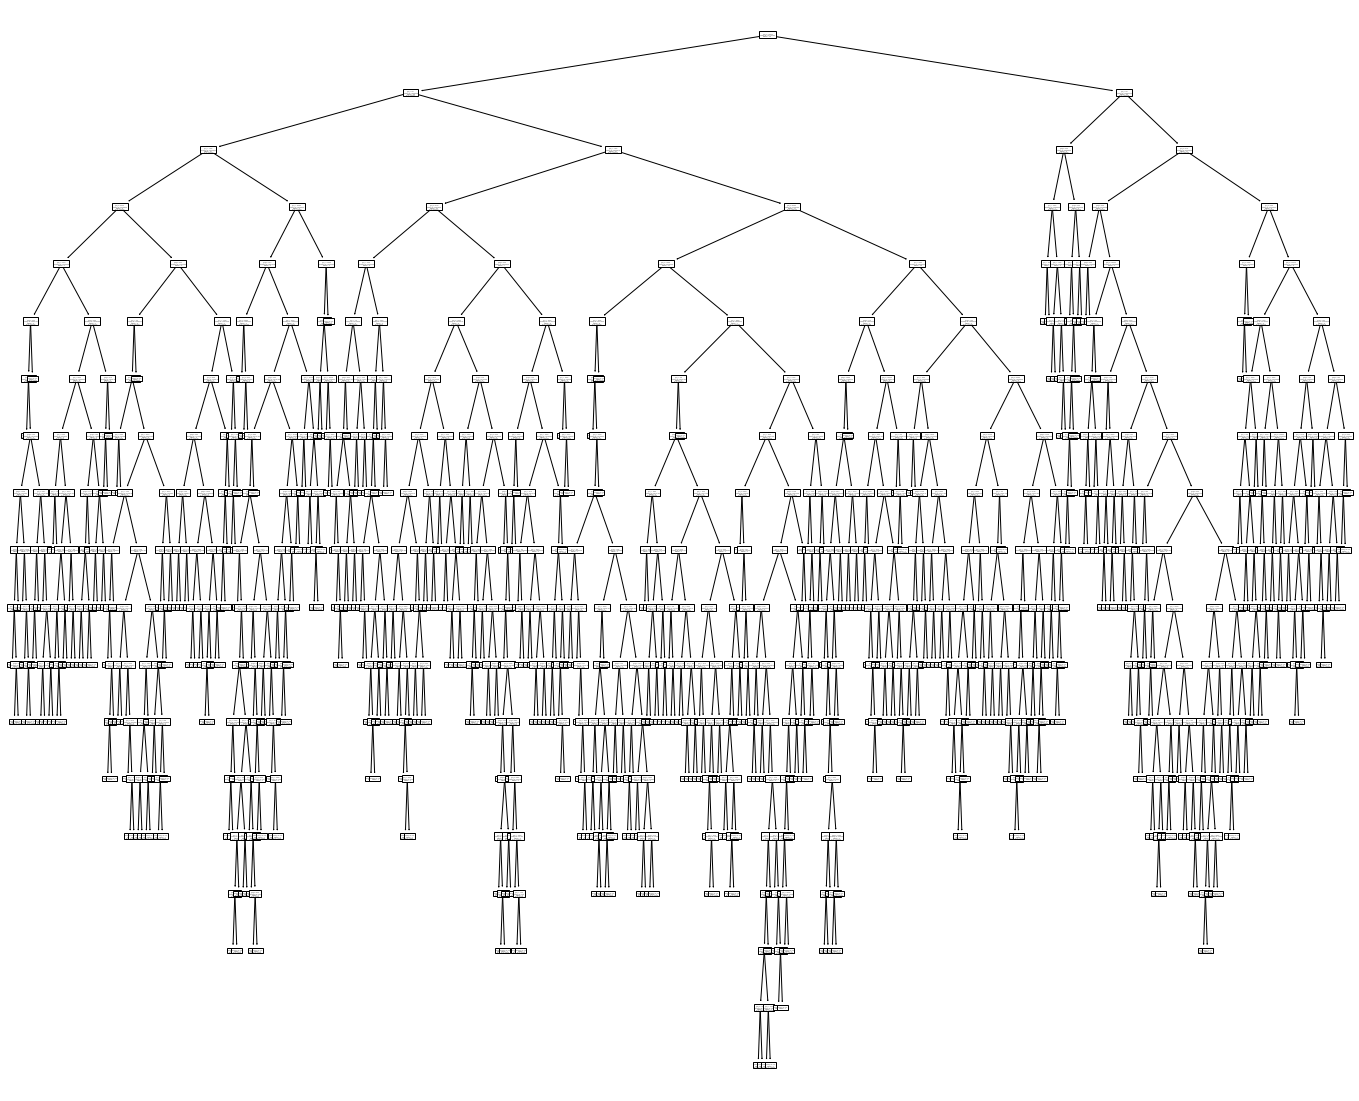

In [440]:
from sklearn.tree import DecisionTreeRegressor

train_x = train_df.drop(['Outstate', 'CollegeNames'], axis=1).assign(Private = train_df['Private']\
        .map({'Yes': 1, 'No': 0}))
train_y = train_df['Outstate']

# Full-grown tree
full_tree_reg = DecisionTreeRegressor(max_depth=None)
full_tree_reg.fit(train_x, train_y)
# plot the tree
from sklearn import tree

plt.figure(figsize=(24,20))
tree.plot_tree(full_tree_reg);


In [400]:
# find the optimal parameters
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

tree_reg_cv = DecisionTreeRegressor()
tree_reg_cv_params = {'max_depth': range(1, 20)}
tree_reg_cv = GridSearchCV(tree_reg_cv, tree_reg_cv_params, cv=20, scoring='neg_mean_squared_error')
tree_reg_cv.fit(train_x, train_y)
tree_reg_cv.best_params_

{'max_depth': 5}

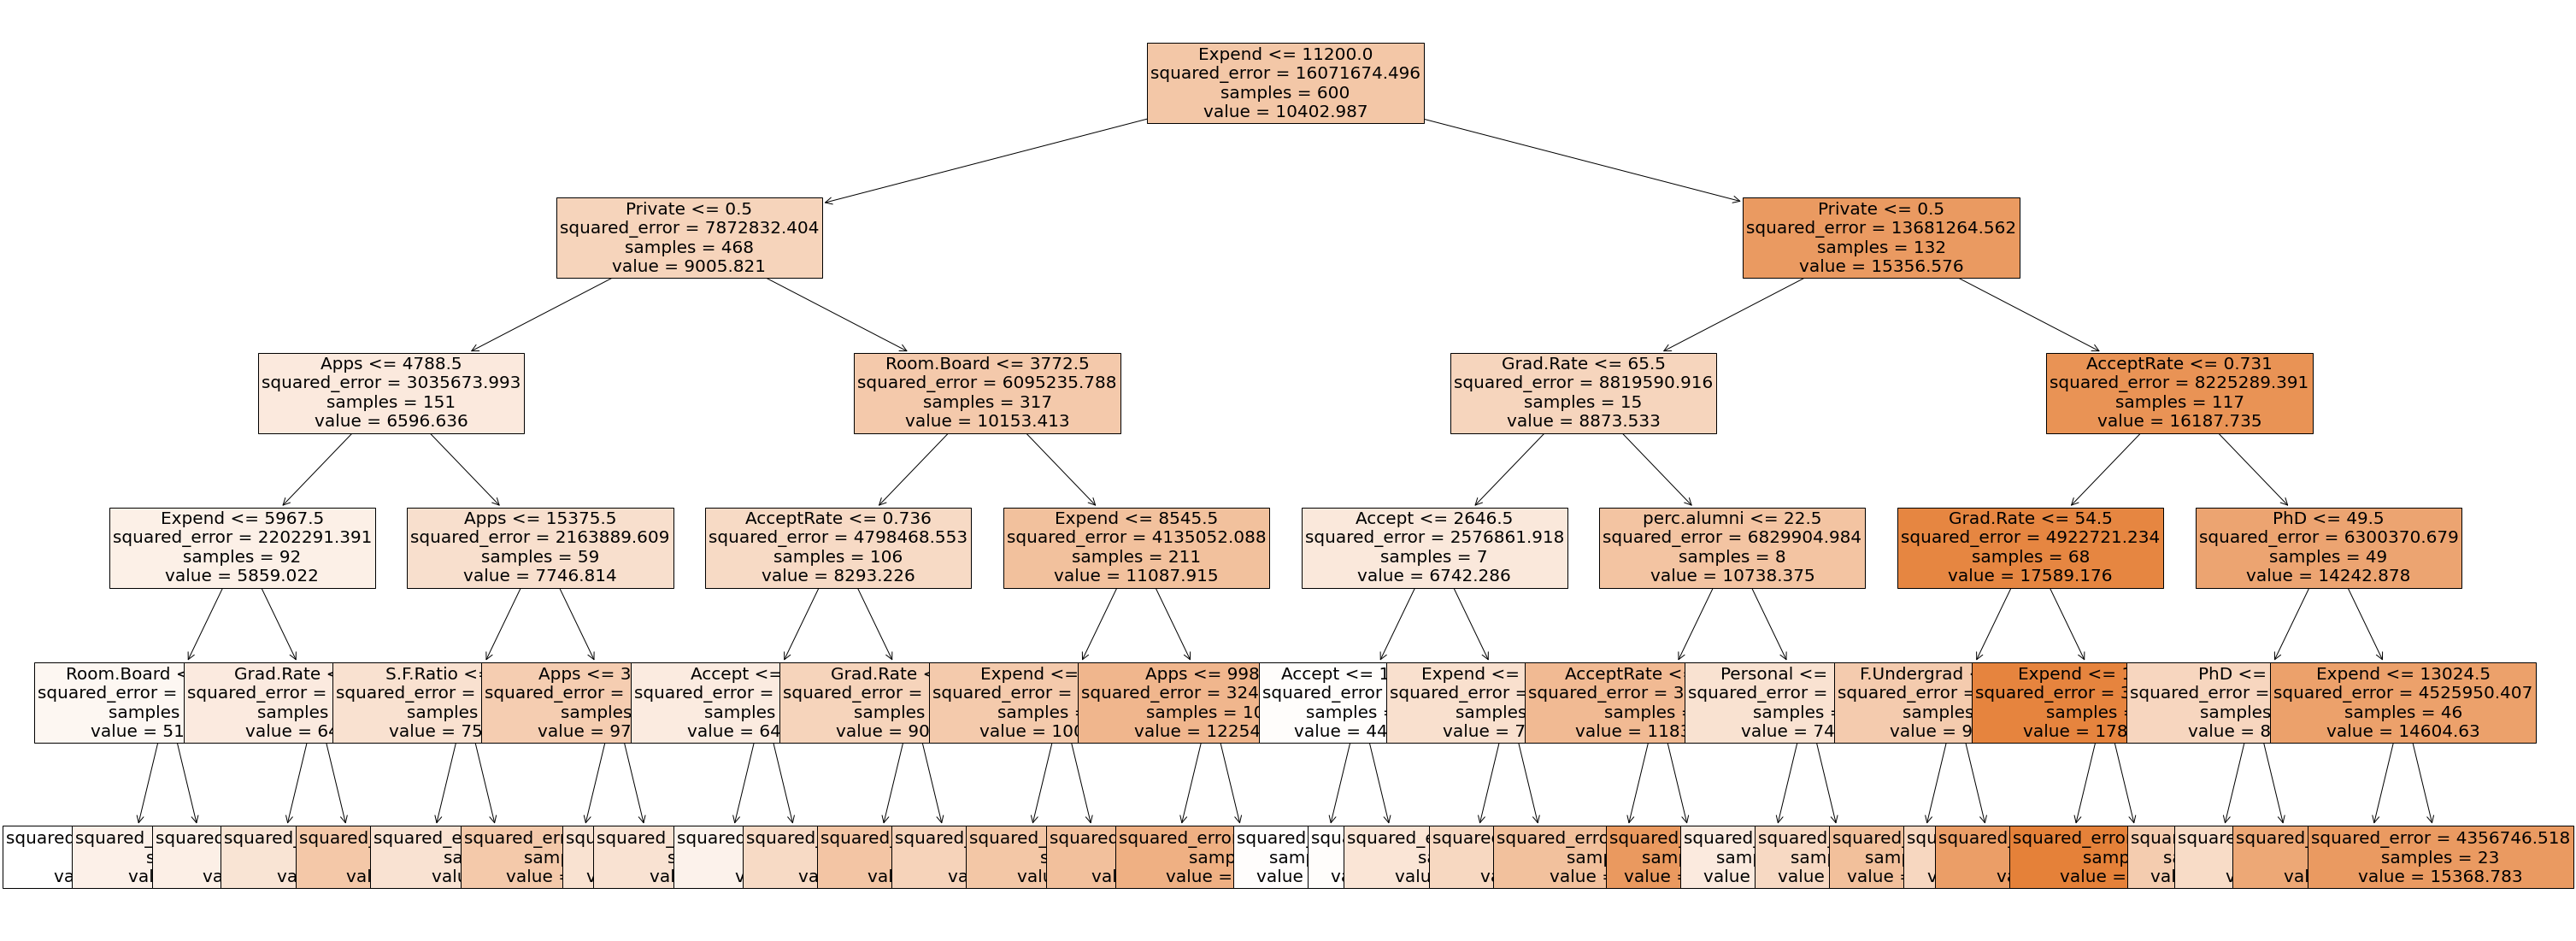

In [438]:
plt.figure(figsize=(50,20))
tree.plot_tree(tree_reg_cv.best_estimator_, filled=True, feature_names=train_x.columns, fontsize=20);

### Part 5 (15 pts)

Finally, let's compare the three models to see which one performs best on the out of sample data. Create predictions using your LASSO model, GAM, full tree, and pruned tree for the out of sample test data. Use these predictions to compute the out of sample MSE for each method. Which performs best? Worst?

In a few sentences, discuss when you think LASSO will work better than GAMs and vice versa. Given our toolset from this week, trees need some work. And we'll do that next week!


In [432]:
def get_MSE(pred_y, true_y):
    return np.mean((pred_y - true_y) ** 2)

test_x = test_df.drop(['Outstate', 'CollegeNames'], axis=1).assign(Private = test_df['Private']\
        .map({'Yes': 1, 'No': 0}))
test_y = test_df['Outstate']

# LASSO
test_x_lasso = pd.DataFrame(scaler_x.transform(test_x), columns= test_x.columns)
print(f'LASSO Test Set MSE: {get_MSE(lasso_reg.predict(test_x_lasso), test_y)}')

# GAM
test_x_gam = test_x[train_x_chosen.columns]
print(f'GAM Test Set MSE: {get_MSE(gam_model.predict(test_x_gam), test_y)}')

# Full-grown tree
print(f'Full-grown tree Test Set MSE: {get_MSE(full_tree_reg.predict(test_x), test_y)}')

# Optimal tree
print(f'Optimal tree Test Set MSE: {get_MSE(tree_reg_cv.best_estimator_.predict(test_x), test_y)}')



LASSO Test Set MSE: 4507811.073670164
GAM Test Set MSE: 3762996.85859725
Full-grown tree Test Set MSE: 6003087.790960452
Optimal tree Test Set MSE: 4344345.480390032


Text(0.5, 1.0, 'Optimal tree, MSE: 4344345.480390032')

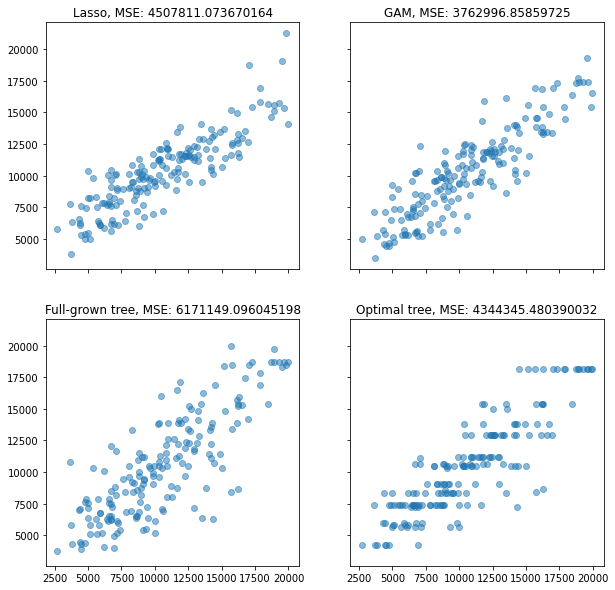

In [443]:
# true vs predicted
fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)

axs[0,0].scatter(test_y, lasso_reg.predict(test_x_lasso), alpha=0.5)
axs[0,0].set_title(f'Lasso, MSE: {get_MSE(lasso_reg.predict(test_x_lasso), test_y)}')

axs[0,1].scatter(test_y, gam_model.predict(test_x_gam), alpha=0.5)
axs[0,1].set_title(f'GAM, MSE: {get_MSE(gam_model.predict(test_x_gam), test_y)}')

axs[1,0].scatter(test_y, full_tree_reg.predict(test_x), alpha=0.5)
axs[1,0].set_title(f'Full-grown tree, MSE: {get_MSE(full_tree_reg.predict(test_x), test_y)}')

axs[1,1].scatter(test_y, tree_reg_cv.best_estimator_.predict(test_x), alpha=0.5)
axs[1,1].set_title(f'Optimal tree, MSE: {get_MSE(tree_reg_cv.best_estimator_.predict(test_x), test_y)}')


Text(0.5, 1.0, 'Optimal tree, MSE: 4344345.480390032')

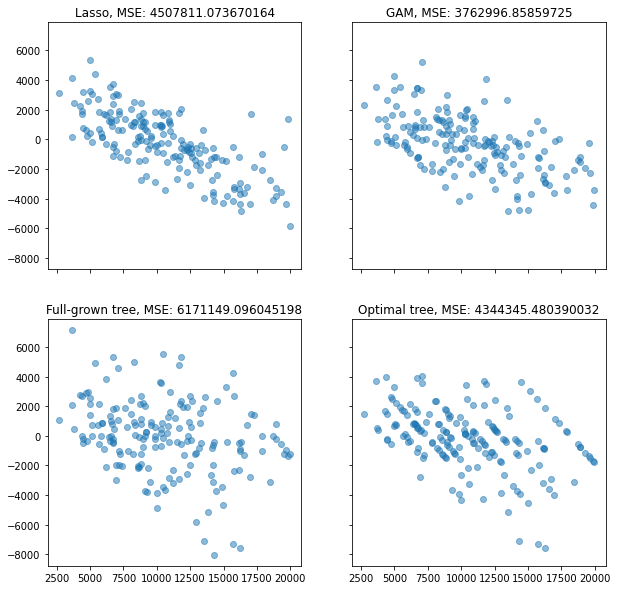

In [444]:
# plot residuals
fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)

axs[0,0].scatter(test_y, lasso_reg.predict(test_x_lasso) - test_y, alpha=0.5)
axs[0,0].set_title(f'Lasso, MSE: {get_MSE(lasso_reg.predict(test_x_lasso), test_y)}')

axs[0,1].scatter(test_y, gam_model.predict(test_x_gam) - test_y, alpha=0.5)
axs[0,1].set_title(f'GAM, MSE: {get_MSE(gam_model.predict(test_x_gam), test_y)}')

axs[1,0].scatter(test_y, full_tree_reg.predict(test_x) - test_y, alpha=0.5)
axs[1,0].set_title(f'Full-grown tree, MSE: {get_MSE(full_tree_reg.predict(test_x), test_y)}')

axs[1,1].scatter(test_y, tree_reg_cv.best_estimator_.predict(test_x) - test_y, alpha=0.5)
axs[1,1].set_title(f'Optimal tree, MSE: {get_MSE(tree_reg_cv.best_estimator_.predict(test_x), test_y)}')

